In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
import kvn
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

18538
/media/work/docs/codes/QuCF/scripts-py


In [2]:
for i in range(30):
    plt.close()

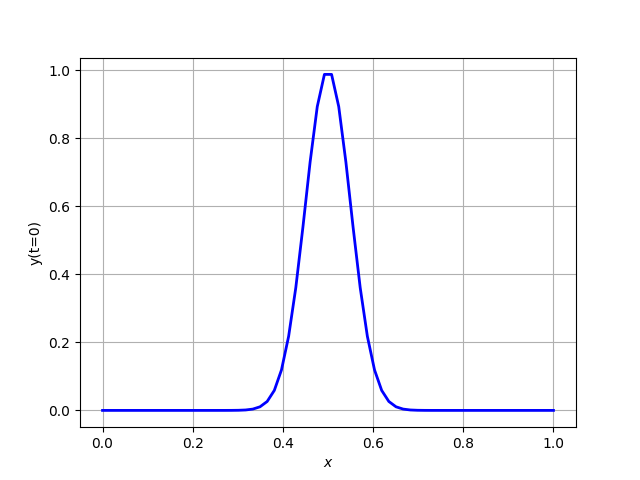

In [15]:
# -----------------------------------------------------------
# --- LCHS parameters ---
# -----------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
def init_cond():
    y_init = np.exp( - (x_ - xc_init_)**2/(2. * width_init_**2))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_init, color='blue', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.ylabel("y(t=0)")
    plt.grid(True)
    plt.show()
    return y_init
# -----------------------------------------------------------

xmax_, nx_, = 1.0, 6
xc_init_ = xmax_/2.
width_init_ = 0.05

# --- resulting parameters ---
rr_ = 3.377008135457e+00

# --- the spatial grid ---
Nx_ = 1 << nx_
x_ = np.linspace(0, xmax_, Nx_)
dx_ = np.diff(x_)[0]

# --- the reference initial profile ---
psi_init_ = init_cond()

Reading the file ../QuCF/simulations/LCHS/ADE-OPT/initialization//init_OUTPUT.hdf5...
Name of the simulation is init
Simulation has been performed  09-25-2024 15:00:11


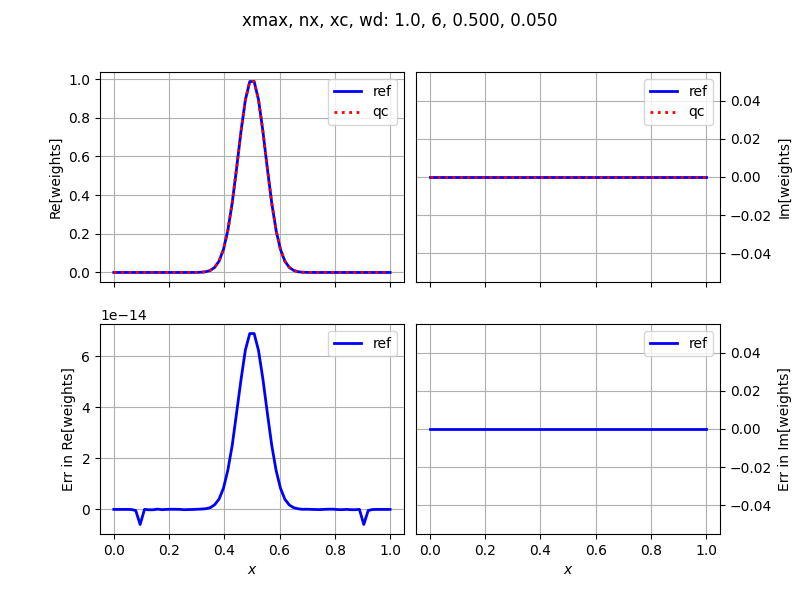

In [18]:
# -----------------------------------------------------------------
# --- QuCF computation of the LCHS weights ---
# -----------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
def QuCF_direct(flag_AA):
    # > When AA is included, keep flag_AA = False, 
    #   to find the amplitude of the amplified signal to compute rr
    # > Set flag_AA = True, when AA is included in QuCF simulations and 
    #   when rr has already been found
    
    y_ref = np.array(psi_init_)
    Hadamart_norm_factor = 2**(nx_/2)

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/ADE-OPT/initialization/"
    om.pname_ = "init"
    om.open()
    Ngates = om.dd_["N-gates"]

    om.set_zero_ancillae_work_states(0)
    y_qc = om.get_var_x({}, "rx")

    succ_prob = np.sum(np.abs(y_qc)**2)
    max_ampl = np.max(np.abs(y_qc))

    # --- renormalization ---
    y_qc *= Hadamart_norm_factor
    if flag_AA:
        y_qc = y_qc / rr_  

    # --- Plotting results ---
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(8, 6)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.subplots_adjust(wspace=0.04)

    axs[0][0].plot(x_, y_ref.real, '-b', linewidth = 2, label = "ref")
    axs[0][0].plot(x_, y_qc.real,  ':r', linewidth = 2, label = "qc")
    axs[0][0].set(ylabel="Re[weights]")
    axs[0][0].legend()
    axs[0][0].grid(True)
    axs[0][0].get_xaxis().set_ticklabels([])

    axs[1][0].plot(x_, y_qc.real - y_ref.real, '-b', linewidth = 2, label = "ref")
    axs[1][0].set(xlabel='$x$', ylabel="Err in Re[weights]")
    axs[1][0].legend()
    axs[1][0].grid(True)
    
    axs[0][1].plot(x_, y_ref.imag, '-b', linewidth = 2, label = "ref")
    axs[0][1].plot(x_, y_qc.imag,  ':r', linewidth = 2, label = "qc")
    axs[0][1].set(ylabel="Im[weights]")
    axs[0][1].legend()
    axs[0][1].grid(True)
    axs[0][1].yaxis.set_label_position("right")
    axs[0][1].yaxis.tick_right()
    axs[0][1].get_xaxis().set_ticklabels([])

    axs[1][1].plot(x_, y_qc.imag - y_ref.imag, '-b', linewidth = 2, label = "ref")
    axs[1][1].set(xlabel='$x$', ylabel="Err in Im[weights]")
    axs[1][1].legend()
    axs[1][1].grid(True)
    axs[1][1].yaxis.set_label_position("right")
    axs[1][1].yaxis.tick_right()

    fig.suptitle("xmax, nx, xc, wd: {:0.1f}, {:d}, {:0.3f}, {:0.3f}".format(
        xmax_, nx_, xc_init_, width_init_
    ))
    plt.show()

    # --- Print some resulting parameters ---
    print()
    if not flag_AA:
        print("A-max (before renorm.): {:0.12e}".format(max_ampl))
        print("success prob. (before renorm.): {:0.12e}".format(succ_prob))
        print()
        print("N-gates: {:d}".format(Ngates))
    return
# ----------------------------------------------------------------------
QuCF_direct(flag_AA = True)

In [14]:
# ----------------------------------------------------------
# --- Amplitude amplification of sqrt(weights) ---
# ----------------------------------------------------------
def print_rr(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------
# *** Here, succ_prob is a non-amplified success probability. ***
def print_NA(line_str, succ_prob):
    theta_AA = np.arcsin(np.sqrt(succ_prob))
    N_AA = int(0.5 * (np.pi/(2.*theta_AA) - 1.))  # +/- 1
    print("{:s}:\t N_AA {:d}".format(line_str, N_AA))
    return
# -----------------------------------------
def compute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("xmax = 1,  nx = 6, xc = 0.5, wd = 0.05", 4.168415844167e-01, 1.234351732944e-01)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("xmax = 1,  nx = 6, xc = 0.5, wd = 0.05", 8.723796297426e-02)
    return
# -----------------------------------------
print("REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.\n")
compute_AA_Dir()

REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.

xmax = 1,  nx = 6, xc = 0.5, wd = 0.05:	 rr = 3.377008135457e+00

xmax = 1,  nx = 6, xc = 0.5, wd = 0.05:	 N_AA 2


In [29]:
print("{:0.12e}".format(1.189338269502e-02/5.964055909265e-03))

1.994176928580e+00


In [ ]:
def copmute_AA_Dir_k40():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 40,  nk =  9", 2.356400466278e-01, 1.189338269502e-02)


    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print_NA("kmax = 40,  nk =  9", 2.547413460272e-03)

    return
# -----------------------------------------
def copmute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,  nk =  5", 4.509140718992e-01, 9.041730755935e-02)
    print_rr("kmax = 10,  nk =  7", 2.407882108182e-01, 2.385477295070e-02)
    print_rr("kmax = 10,  nk =  9", 1.209326248815e-01, 5.972057127441e-03)
    print_rr("kmax = 20,  nk =  8", 2.360314611587e-01, 1.683584766872e-02)
    print_rr("kmax = 80,  nk = 10", 2.353225905368e-01, 8.405869057308e-03)
    print_rr("kmax = 100, nk =  9", 3.640610080762e-01, 1.837972321295e-02)
    print_rr("kmax = 160, nk = 11", 2.353012421820e-01, 5.942423738809e-03)
    
    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,  nk =  5", 3.890587488107e-02)
    print_NA("kmax = 10,  nk =  7", 9.738781664262e-03)
    print_NA("kmax = 10,  nk =  9", 2.434706684172e-03)
    print_NA("kmax = 20,  nk =  8", 5.058512304123e-03)
    print_NA("kmax = 80,  nk = 10", 1.274360075294e-03)
    print_NA("kmax = 100, nk =  9", 2.548697367493e-03)
    print_NA("kmax = 160, nk = 11", 6.371852419263e-04)
    return